In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Team-AY/FER-NN-dacl

import os
os.chdir('/content/FER-NN-dacl')

!pwd

Cloning into 'FER-NN-dacl'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 41 (delta 14), reused 16 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 183.12 KiB | 951.00 KiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/FER-NN-dacl


In [3]:
!gdown 1u2NtY-5DVlTunfN4yxfxys5n8uh7sc3n -O models/

Downloading...
From (original): https://drive.google.com/uc?id=1u2NtY-5DVlTunfN4yxfxys5n8uh7sc3n
From (redirected): https://drive.google.com/uc?id=1u2NtY-5DVlTunfN4yxfxys5n8uh7sc3n&confirm=t&uuid=c624c4fa-ae95-4827-b91a-8842ea63445a
To: /content/FER-NN-dacl/models/resnet18_msceleb.pth
100% 182M/182M [00:05<00:00, 33.3MB/s]


In [ ]:
!python main.py

2024-10-13 11:36:59.525318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 11:36:59.562419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 11:36:59.573491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 11:36:59.597731: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 11:37:01.100128: W tensorflow/compiler/tf2

<h1>Results Script</h1>

In [7]:
import sys
sys.path.append('/content/FER-NN/model-DACL/models')

In [8]:
#import libraries and setup
import torch
from torchvision import transforms
import torch.utils.data as data

import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
from PIL import Image
import os
from models import resnet18
import torch.nn as nn

%matplotlib inline

<h3>Functions Definitions</h3>

In [9]:
#load the dataset for the DACL model
def loaddata(root, bs, workers, normalize):


  val_loader = torch.utils.data.DataLoader(
            dataset=datasets.ImageFolder(
                root=os.path.join(root, 'test'),
                transform=transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])
            ),
            batch_size=bs, shuffle=False,
            num_workers=workers, pin_memory=True
        )

  return val_loader




In [10]:
def evaluate_model(model, test_loader, device):
    all_preds = []
    all_labels = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:  # Loop through batches
            images = images.to(device) # Move images to the device
            labels = labels.to(device) # Move labels to the device
            _, predictions, *_ = model(images)
            _, predicted_labels = torch.max(predictions, 1)

            all_preds.extend(predicted_labels.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store actual labels

    accuracy = accuracy_score(all_labels, all_preds)
    conf_mat = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, output_dict=True)

    return accuracy, conf_mat, class_report

In [11]:
def load_model(checkpoint_path, model):
    """""
    Args: checkpoint_path (str): Path to the checkpoint file.
    Set model to evaluation mode
    Returns: torch.nn.Module: Loaded model.
    """""
    checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    return model

In [13]:
def loop_func(model_checkpoints,path,val_loader, device):

  model_names = []
  accuracies = []
  conf_mats = []
  class_reports = []

  model = resnet18(pretrained='msceleb')
  model.fc = torch.nn.Linear(512, 7)
  model = torch.nn.DataParallel(model)

  # Loop through each model checkpoint, load the model and evaluate
  for checkpoint in model_checkpoints:
      checkpoint_path = os.path.join(path, checkpoint)
      loaded_model = load_model(checkpoint_path,model)
      loaded_model = loaded_model.to(device)
      accuracy, conf_mat, class_report = evaluate_model(loaded_model, val_loader,device)

      model_names.append(checkpoint)
      accuracies.append(accuracy)
      conf_mats.append(conf_mat)
      class_reports.append(class_report)

  return model_names, accuracies, conf_mats, class_reports

In [20]:


rafnormalize = transforms.Normalize(mean=[0.5752, 0.4495, 0.4012],
                                     std=[0.2086, 0.1911, 0.1827])


rafpath = '/content/drive/MyDrive/Final_Project/Models_cheackpoints/DACL/raf_normalization'
model_checkpoints = ['fer2013_batch-256_rafnorm.pth', 'fer2013_batch-128_rafnorm.pth', 'fer2013_batch-64_rafnorm.pth']

root = '/content/drive/MyDrive/Final_Project/Databases/fer2013_Face_1'

rafval_loader = loaddata(root, 128, 2, rafnormalize)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [21]:
model_names, accuracies, conf_mats, class_reports = loop_func(model_checkpoints,rafpath,rafval_loader, device)

[!] initializing model with "msceleb" weights ...


/content/FER-NN-dacl/models/resnet.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  msceleb_model = torch.load('/content/FER-NN-dacl/models/resnet18_msceleb.pth',map_lo

In [40]:
import json
# Create a dictionary to hold all the data
raf_results = {
    'model_names': model_names,
    'accuracies': accuracies,
    'confusion_matrices': [cm.tolist() for cm in conf_mats], # Convert to list
    'classification_reports': [cr for cr in class_reports] # Assuming it's serializable
}

# Save to JSON file
with open('DACL_model_results.json', 'w') as f:
    json.dump(raf_results, f)

print('Confusion matrices and classification reports saved to raf_model_results.json')


Confusion matrices and classification reports saved to raf_model_results.json


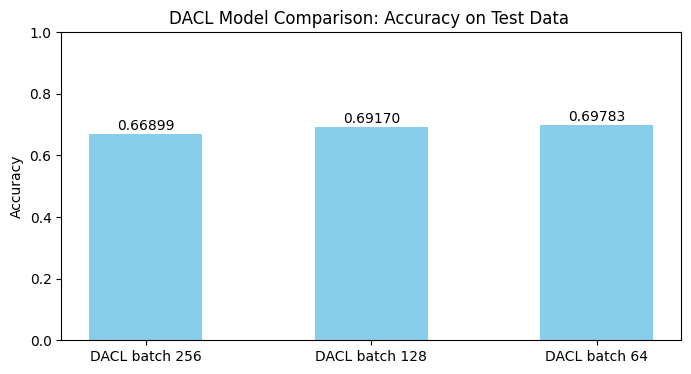

In [27]:
# 1. Plot model accuracies for comparison
model_names = ['DACL batch 256', 'DACL batch 128', 'DACL batch 64']
plt.figure(figsize=(8, 4))
plt.bar(model_names, accuracies, color='skyblue',  width=0.5)
plt.ylim(0, 1)

for i, (model_name, accuracy) in enumerate(zip(model_names, accuracies)):
  x_pos = i  # Adjust x position if needed (e.g., for center alignment)
  y_pos = accuracy + 0.005  # Adjust y position for some space above the bar

  plt.text(x_pos, y_pos, f"{accuracy:.5f}", ha='center', va='bottom')  # Format and align the label

  plt.ylabel('Accuracy')
  plt.title('DACL Model Comparison: Accuracy on Test Data ')

plt.savefig(f'DACL Model Comparison: Accuracy on Test Data')
plt.show()

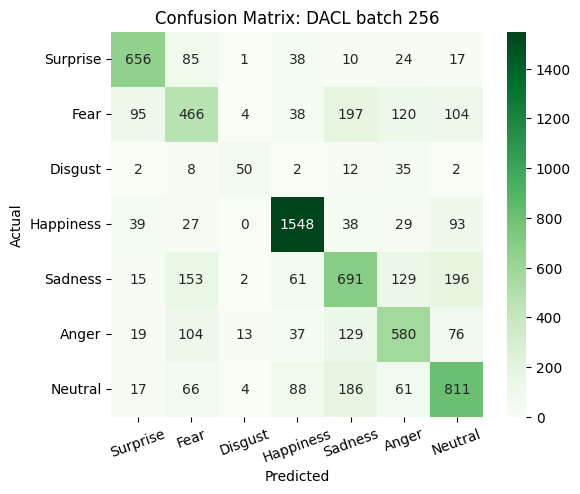

---------------


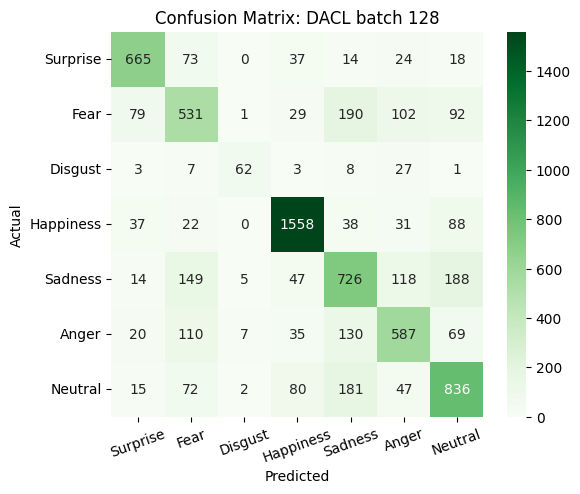

---------------


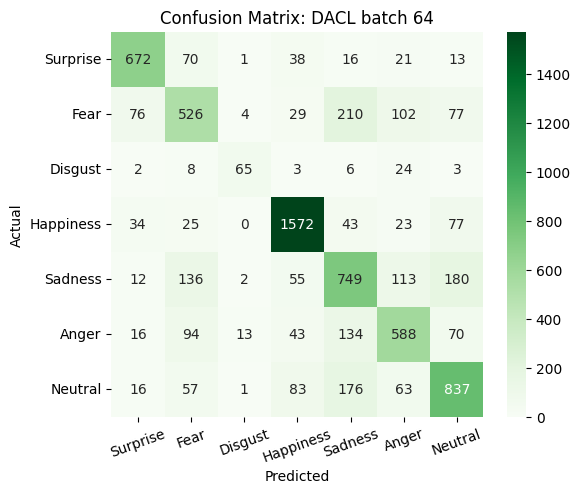

---------------


In [38]:
# 2. Plot Confusion Matrices
labels = ['Surprise' ,'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
for i, conf_mat in enumerate(conf_mats):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    txt = model_names[i].split(".")
    plt.title(f'Confusion Matrix: {txt[0]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=20)
    plt.savefig(f'Confusion Matrix fernorm: {txt[0]}',dpi=300, bbox_inches='tight', pad_inches=0.4)
    plt.show()
    print("---------------")

In [39]:
print("DACL model class reports")
# 3. Print Classification Reports for each model
for i, class_report in enumerate(class_reports):

    class_report_df = pd.DataFrame(class_report).transpose()
    new_labels = labels
    class_report_df.index = new_labels + ['accuracy', 'macro avg', 'weighted avg']
    print("")
    print("")
    print("----------------------------------------------------")
    txt = model_names[i].split(".")
    print(f'Classification Report: {txt[0]}')
    print(class_report_df)

DACL model class reports


----------------------------------------------------
Classification Report: DACL batch 256
              precision    recall  f1-score      support
Surprise       0.778173  0.789410  0.783751   831.000000
Fear           0.512651  0.455078  0.482152  1024.000000
Disgust        0.675676  0.450450  0.540541   111.000000
Happiness      0.854305  0.872604  0.863358  1774.000000
Sadness        0.547110  0.554130  0.550598  1247.000000
Anger          0.593047  0.605428  0.599174   958.000000
Neutral        0.624326  0.657745  0.640600  1233.000000
accuracy       0.668989  0.668989  0.668989     0.668989
macro avg      0.655041  0.626407  0.637168  7178.000000
weighted avg   0.666249  0.668989  0.666910  7178.000000


----------------------------------------------------
Classification Report: DACL batch 128
              precision    recall  f1-score      support
Surprise       0.798319  0.800241  0.799279   831.000000
Fear           0.550830  0.518555  0.534205  102